#Import

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 80.1 MB/s 
     |████████████████████████████████| 895 kB 60.6 MB/s 
     |████████████████████████████████| 6.5 MB 57.0 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
!/opt/bin/nvidia-smi

Wed Mar 16 20:24:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

#read dataset

In [ ]:

train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/4192/Data/DirectCompare/train_df.csv")

train_df = train_df[['selftext','Expert-label']]
train_df[['Expert-label']] = train_df[['Expert-label']].astype(int)
train_df

,selftext,Expert-label
0,I posted this on Piazza but thought I might as...,1
1,"Hi i’ve applied for arts from Vancouver,BC as ...",0
2,i'm an international student and i've been tak...,1
3,i'm an international student and the midterm w...,1
4,they think i wouldnt be able to handle the str...,0
...,...,...
997,My boyfriend is Canadian and I’m American. Obv...,0
998,Do you need to be vaccinated to travel domesti...,0
999,"Hello, are there any International students he...",1
1000,Will you guys take a leave of absence? Or are ...,0


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/4192/Data/Validation988/988validation.csv")

test_df = test_df[['selftext']]
test_df.insert(test_df.shape[1], 'label', 1)
test_df

,selftext,label
0,Well... I think I need some help... about depr...,1
1,I am an international student and i started en...,1
2,i'm an international student and the midterm w...,1
3,"Honestly just want to end it all , it’s so har...",1
4,"Hi all, \n\nI'm really upset to know the Winte...",1
...,...,...
983,WE NEED A SCIENCE AND DATA BASED APPROACH TO C...,1
984,Hi everyone! Hope that all who are applying ar...,1
985,Hello everyone !\n\nI request some advice from...,1
986,"Hi, I was wondering what my chances were at th...",1


##data prepration

In [ ]:
X_train = train_df["selftext"].values.tolist()
y_train = train_df["Expert-label"].values.tolist()
X_val = test_df["selftext"].values.tolist()
y_val = test_df["label"].values.tolist()



##torch dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])



##Metrics

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

#Models

##SciBERT

In [ ]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

###epoch=3

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

In [ ]:
trainer_sci = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_sci.train()

***** Running training *****
  Num examples = 1002
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 93


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.042321,0.330972,1.000000,0.330972,0.497338
50,No log,1.553313,0.045547,1.000000,0.045547,0.087125
75,No log,1.510696,0.169028,1.000000,0.169028,0.289177


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=93, training_loss=0.6075086696173555, metrics={'train_runtime': 246.6366, 'train_samples_per_second': 12.188, 'train_steps_per_second': 0.377, 'total_flos': 788280721858560.0, 'train_loss': 0.6075086696173555, 'epoch': 2.99})

###epoch=6

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=6,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

In [ ]:
trainer_sci_6 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_sci_6.train()

***** Running training *****
  Num examples = 1002
  Num Epochs = 6
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 186


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.099229,0.239879,1.000000,0.239879,0.386939
50,No log,1.570231,0.114372,1.000000,0.114372,0.205268
75,No log,1.769751,0.172065,1.000000,0.172065,0.293610
100,No log,1.819309,0.252024,1.000000,0.252024,0.402587
125,No log,2.401219,0.161943,1.000000,0.161943,0.278746
150,No log,2.190536,0.224696,1.000000,0.224696,0.366942
175,No log,2.533719,0.180162,1.000000,0.180162,0.305317


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=186, training_loss=0.4460338059292045, metrics={'train_runtime': 524.4684, 'train_samples_per_second': 11.463, 'train_steps_per_second': 0.355, 'total_flos': 1579192554270720.0, 'train_loss': 0.4460338059292045, 'epoch': 5.99})

###epoch=9

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=9,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

In [ ]:
trainer_sci_9 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_sci_9.train()

***** Running training *****
  Num examples = 1002
  Num Epochs = 9
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 279


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.042184,0.156883,1.000000,0.156883,0.271216
50,No log,1.288229,0.134615,1.000000,0.134615,0.237288
75,No log,1.579396,0.193320,1.000000,0.193320,0.324003
100,No log,2.054889,0.189271,1.000000,0.189271,0.318298
125,No log,2.249748,0.153846,1.000000,0.153846,0.266667
150,No log,2.531972,0.187247,1.000000,0.187247,0.315431
175,No log,3.001111,0.164980,1.000000,0.164980,0.283232
200,No log,2.676663,0.256073,1.000000,0.256073,0.407736
225,No log,4.048328,0.116397,1.000000,0.116397,0.208522
250,No log,3.700036,0.178138,1.000000,0.178138,0.302405


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=279, training_loss=0.27450225173786125, metrics={'train_runtime': 792.4637, 'train_samples_per_second': 11.38, 'train_steps_per_second': 0.352, 'total_flos': 2370104386682880.0, 'train_loss': 0.27450225173786125, 'epoch': 8.99})

##PSY

In [ ]:
model_name = "nlp4good/psych-search"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )

Some weights of the model checkpoint at nlp4good/psych-search were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlp4good/psych-search a

In [ ]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

###epoch=3

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer_psy = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_psy.train()

***** Running training *****
  Num examples = 1002
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 93


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.249074,0.042510,1.000000,0.042510,0.081553
50,No log,1.728763,0.121457,1.000000,0.121457,0.216606
75,No log,1.897291,0.157895,1.000000,0.157895,0.272727


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=93, training_loss=0.56231689453125, metrics={'train_runtime': 246.524, 'train_samples_per_second': 12.194, 'train_steps_per_second': 0.377, 'total_flos': 788280721858560.0, 'train_loss': 0.56231689453125, 'epoch': 2.99})

###epoch=6

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=6,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer_psy_6 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_psy_6.train()

***** Running training *****
  Num examples = 1002
  Num Epochs = 6
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 186


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,6.266512,0.205466,1.000000,0.205466,0.340890
50,No log,7.144855,0.170040,1.000000,0.170040,0.290657
75,No log,7.206092,0.151822,1.000000,0.151822,0.263620
100,No log,5.402030,0.150810,1.000000,0.150810,0.262093
125,No log,5.408955,0.185223,1.000000,0.185223,0.312553
150,No log,6.578726,0.133603,1.000000,0.133603,0.235714
175,No log,6.356332,0.153846,1.000000,0.153846,0.266667


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=186, training_loss=0.04805446952901861, metrics={'train_runtime': 522.7205, 'train_samples_per_second': 11.501, 'train_steps_per_second': 0.356, 'total_flos': 1579192554270720.0, 'train_loss': 0.04805446952901861, 'epoch': 5.99})

###epoch=9

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=9,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer_psy_9 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_psy_9.train()

***** Running training *****
  Num examples = 1002
  Num Epochs = 9
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 279


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,8.373548,0.165992,1.000000,0.165992,0.284722
50,No log,6.484338,0.212551,1.000000,0.212551,0.350584
75,No log,8.190551,0.146761,1.000000,0.146761,0.255958
100,No log,8.226768,0.141700,1.000000,0.141700,0.248227
125,No log,7.063513,0.191296,1.000000,0.191296,0.321155
150,No log,9.005898,0.093117,1.000000,0.093117,0.170370
175,No log,7.540215,0.197368,1.000000,0.197368,0.329670
200,No log,8.464607,0.130567,1.000000,0.130567,0.230976
225,No log,8.451786,0.141700,1.000000,0.141700,0.248227
250,No log,8.410789,0.139676,1.000000,0.139676,0.245115


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=279, training_loss=0.02872309804389981, metrics={'train_runtime': 793.878, 'train_samples_per_second': 11.359, 'train_steps_per_second': 0.351, 'total_flos': 2370104386682880.0, 'train_loss': 0.02872309804389981, 'epoch': 8.99})

#Outputs

##SciBERT

###epoch=3

In [ ]:
trainer_sci.evaluate()

***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


{'epoch': 2.99,
 'eval_accuracy': 0.14979757085020243,
 'eval_f1': 0.2605633802816901,
 'eval_loss': 1.6332290172576904,
 'eval_precision': 1.0,
 'eval_recall': 0.14979757085020243,
 'eval_runtime': 21.0314,
 'eval_samples_per_second': 46.977,
 'eval_steps_per_second': 23.489}

###epoch=6

In [ ]:
trainer_sci_6.evaluate()

***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


{'epoch': 5.99,
 'eval_accuracy': 0.1700404858299595,
 'eval_f1': 0.29065743944636674,
 'eval_loss': 2.6157729625701904,
 'eval_precision': 1.0,
 'eval_recall': 0.1700404858299595,
 'eval_runtime': 21.5487,
 'eval_samples_per_second': 45.85,
 'eval_steps_per_second': 22.925}

###epoch=9

In [ ]:
trainer_sci_9.evaluate()

***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


{'epoch': 8.99,
 'eval_accuracy': 0.19635627530364372,
 'eval_f1': 0.32825719120135366,
 'eval_loss': 3.6765050888061523,
 'eval_precision': 1.0,
 'eval_recall': 0.19635627530364372,
 'eval_runtime': 21.4206,
 'eval_samples_per_second': 46.124,
 'eval_steps_per_second': 23.062}

##PSY

###epoch=3

In [ ]:
trainer_psy.evaluate()

***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


{'epoch': 2.99,
 'eval_accuracy': 0.19230769230769232,
 'eval_f1': 0.32258064516129037,
 'eval_loss': 1.8422211408615112,
 'eval_precision': 1.0,
 'eval_recall': 0.19230769230769232,
 'eval_runtime': 21.0253,
 'eval_samples_per_second': 46.991,
 'eval_steps_per_second': 23.496}

###epoch=6

In [ ]:
trainer_psy_6.evaluate()

***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


{'epoch': 5.99,
 'eval_accuracy': 0.13663967611336034,
 'eval_f1': 0.24042742653606414,
 'eval_loss': 6.61625337600708,
 'eval_precision': 1.0,
 'eval_recall': 0.13663967611336034,
 'eval_runtime': 21.4276,
 'eval_samples_per_second': 46.109,
 'eval_steps_per_second': 23.054}

###epoch=9

In [ ]:
trainer_psy_9.evaluate()

***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


{'epoch': 8.99,
 'eval_accuracy': 0.12854251012145748,
 'eval_f1': 0.22780269058295963,
 'eval_loss': 8.521716117858887,
 'eval_precision': 1.0,
 'eval_recall': 0.12854251012145748,
 'eval_runtime': 21.361,
 'eval_samples_per_second': 46.252,
 'eval_steps_per_second': 23.126}

#epoch test

In [ ]:
sci_epoch_range = range(3,31,3)
sci_recall_list = []




for i in sci_epoch_range:

  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )


  
  args = TrainingArguments(
      output_dir="output",
      evaluation_strategy="steps",
      eval_steps=25,
      per_device_train_batch_size=2,
      per_device_eval_batch_size=2,
      num_train_epochs=i,
      seed=0,
      load_best_model_at_end=True,
      overwrite_output_dir=True,
      learning_rate=3e-5,
      gradient_accumulation_steps=16
  )

  trainer_sci_tmp = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
  ) 

  trainer_sci_tmp.train()
  tmp_eval = trainer_sci_tmp.evaluate()
  sci_recall_list.append(tmp_eval['eval_recall'])


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.315965,0.029352,1.000000,0.029352,0.057030
50,No log,1.562269,0.064777,1.000000,0.064777,0.121673
75,No log,1.662449,0.110324,1.000000,0.110324,0.198724


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.846267,0.367409,1.000000,0.367409,0.537380
50,No log,1.219027,0.216599,1.000000,0.216599,0.356073
75,No log,1.569018,0.195344,1.000000,0.195344,0.326842
100,No log,1.745092,0.239879,1.000000,0.239879,0.386939
125,No log,2.644949,0.071862,1.000000,0.071862,0.134089
150,No log,2.524228,0.119433,1.000000,0.119433,0.213382
175,No log,2.751083,0.103239,1.000000,0.103239,0.187156


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.139641,0.168016,1.000000,0.168016,0.287695
50,No log,1.340565,0.162955,1.000000,0.162955,0.280244
75,No log,1.870145,0.216599,1.000000,0.216599,0.356073
100,No log,2.309189,0.194332,1.000000,0.194332,0.325424
125,No log,3.542300,0.093117,1.000000,0.093117,0.170370
150,No log,3.604902,0.162955,1.000000,0.162955,0.280244
175,No log,4.483225,0.092105,1.000000,0.092105,0.168675
200,No log,3.255684,0.258097,1.000000,0.258097,0.410298
225,No log,4.656199,0.133603,1.000000,0.133603,0.235714
250,No log,4.582757,0.154858,1.000000,0.154858,0.268186


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.143986,0.160931,1.000000,0.160931,0.277245
50,No log,1.560146,0.028340,1.000000,0.028340,0.055118
75,No log,1.261744,0.307692,1.000000,0.307692,0.470588
100,No log,2.280637,0.041498,1.000000,0.041498,0.079689
125,No log,2.912281,0.057692,1.000000,0.057692,0.109091
150,No log,2.455578,0.211538,1.000000,0.211538,0.349206
175,No log,2.954658,0.226721,1.000000,0.226721,0.369637
200,No log,2.886551,0.282389,1.000000,0.282389,0.440410
225,No log,4.146486,0.112348,1.000000,0.112348,0.202002
250,No log,3.281456,0.253036,1.000000,0.253036,0.403877


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forge

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.113923,0.009109,1.000000,0.009109,0.018054
50,No log,1.564524,0.138664,1.000000,0.138664,0.243556
75,No log,2.348560,0.126518,1.000000,0.126518,0.224618
100,No log,2.399947,0.147773,1.000000,0.147773,0.257496
125,No log,3.624411,0.091093,1.000000,0.091093,0.166976
150,No log,3.404746,0.135628,1.000000,0.135628,0.238859
175,No log,4.288368,0.111336,1.000000,0.111336,0.200364
200,No log,3.396213,0.261134,1.000000,0.261134,0.414125
225,No log,4.270241,0.198381,1.000000,0.198381,0.331081
250,No log,4.302343,0.212551,1.000000,0.212551,0.350584


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.070922,0.257085,1.000000,0.257085,0.409018
50,No log,1.469890,0.184211,1.000000,0.184211,0.311111
75,No log,1.678418,0.188259,1.000000,0.188259,0.316865
100,No log,2.416969,0.105263,1.000000,0.105263,0.190476
125,No log,3.325831,0.051619,1.000000,0.051619,0.098171
150,No log,2.844161,0.125506,1.000000,0.125506,0.223022
175,No log,4.065267,0.102227,1.000000,0.102227,0.185491
200,No log,3.865581,0.151822,1.000000,0.151822,0.263620
225,No log,5.083966,0.099190,1.000000,0.099190,0.180479
250,No log,5.346222,0.092105,1.000000,0.092105,0.168675


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.173175,0.009109,1.000000,0.009109,0.018054
50,No log,1.496552,0.172065,1.000000,0.172065,0.293610
75,No log,1.885052,0.208502,1.000000,0.208502,0.345059
100,No log,2.128182,0.236842,1.000000,0.236842,0.382979
125,No log,3.749450,0.089069,1.000000,0.089069,0.163569
150,No log,4.313660,0.097166,1.000000,0.097166,0.177122
175,No log,3.807053,0.214575,1.000000,0.214575,0.353333
200,No log,3.502484,0.314777,1.000000,0.314777,0.478830
225,No log,3.924337,0.228745,1.000000,0.228745,0.372323
250,No log,3.927816,0.224696,1.000000,0.224696,0.366942


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.281368,0.129555,1.000000,0.129555,0.229391
50,No log,1.421737,0.190283,1.000000,0.190283,0.319728
75,No log,1.579962,0.231781,1.000000,0.231781,0.376335
100,No log,1.935137,0.219636,1.000000,0.219636,0.360166
125,No log,3.233432,0.097166,1.000000,0.097166,0.177122
150,No log,3.978019,0.082996,1.000000,0.082996,0.153271
175,No log,3.787308,0.145749,1.000000,0.145749,0.254417
200,No log,3.469918,0.225709,1.000000,0.225709,0.368291
225,No log,3.671619,0.264170,1.000000,0.264170,0.417934
250,No log,4.723198,0.143725,1.000000,0.143725,0.251327


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.271142,0.136640,1.000000,0.136640,0.240427
50,No log,1.429243,0.154858,1.000000,0.154858,0.268186
75,No log,1.788036,0.169028,1.000000,0.169028,0.289177
100,No log,2.203613,0.126518,1.000000,0.126518,0.224618
125,No log,3.353783,0.094130,1.000000,0.094130,0.172063
150,No log,3.187804,0.127530,1.000000,0.127530,0.226212
175,No log,4.117231,0.117409,1.000000,0.117409,0.210145
200,No log,4.036572,0.164980,1.000000,0.164980,0.283232
225,No log,4.621170,0.133603,1.000000,0.133603,0.235714
250,No log,4.325041,0.155870,1.000000,0.155870,0.269702


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.280156,0.117409,1.000000,0.117409,0.210145
50,No log,1.641697,0.087045,1.000000,0.087045,0.160149
75,No log,1.841269,0.178138,1.000000,0.178138,0.302405
100,No log,2.027132,0.200405,1.000000,0.200405,0.333895
125,No log,3.828673,0.040486,1.000000,0.040486,0.077821
150,No log,2.551726,0.209514,1.000000,0.209514,0.346444
175,No log,3.545934,0.182186,1.000000,0.182186,0.308219
200,No log,2.933459,0.303644,1.000000,0.303644,0.465839
225,No log,4.000411,0.195344,1.000000,0.195344,0.326842
250,No log,4.191019,0.185223,1.000000,0.185223,0.312553


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  N

In [ ]:
from matplotlib import pyplot as plt

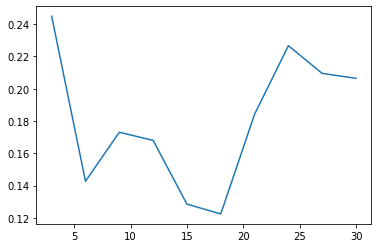

In [ ]:
plt.plot(range(3,31,3),sci_recall_list)

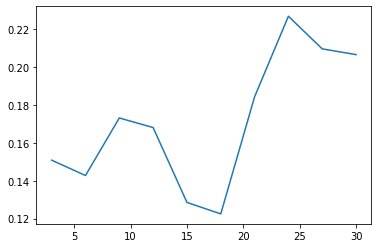

In [ ]:
plt.plot(range(3,31,3),sci_recall_list)